In [115]:
#Primary analysis workflow for tissue-based XYZseq experiments
#demo data: 20181110_DSP

In [207]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy.api as sc

In [214]:
#designate working directory 
#path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
#for scanpy annotations: barcodes.tsv, genes.tsv
#
#

path="./data/20181110_DSP/"

#get and format the data

array_columns=['gene','cell','count']

count_matrix=pd.read_csv(path + 'matrix.mtx', sep=' ', header=None, index_col=None, skiprows=3, names=array_columns)

#check the format of the data
count_matrix.head()

,gene,cell,count
0,100497,1,1
1,101205,1,1
2,101663,1,1
3,106687,1,5
4,106691,1,7


number of UMIs total: 15000285
number of cells: 7143


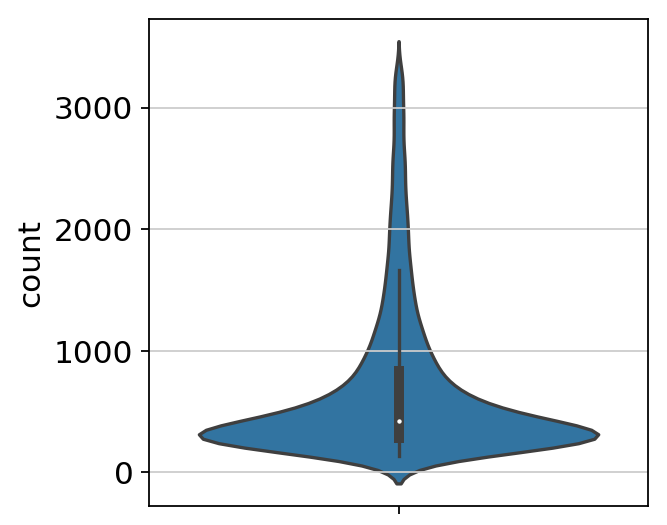

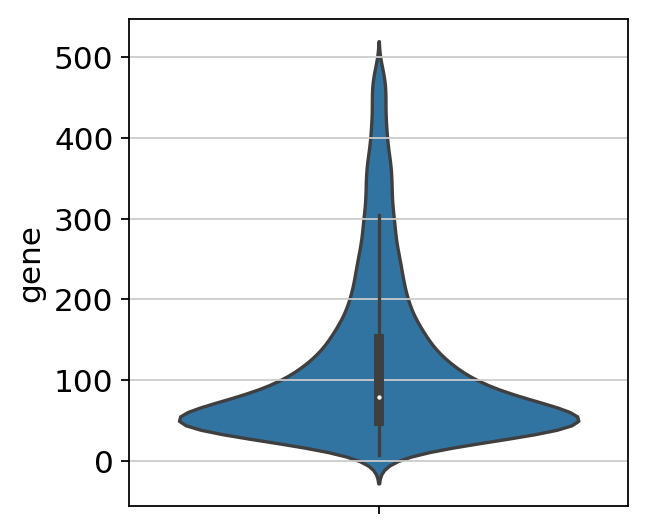

In [215]:
##show some metrics for the data 

total_UMIS=count_matrix['count'].sum()
cell_number=count_matrix['cell'].nunique()


print("number of UMIs total:", total_UMIS)
print("number of cells:", cell_number)


#cell number, median UMIs and genes per cell, top genes



#UMIs per cell
UMIs=count_matrix.groupby('cell')['count'].sum()

q=UMIs.quantile(0.90)
UMIs=UMIs[UMIs < q]

sns.violinplot(UMIs, orient='v')
plt.show()

#genes per cell
genes=count_matrix.groupby('cell')['gene'].nunique()

q=genes.quantile(0.90)
genes=genes[genes < q]


sns.violinplot(genes, orient='v')
plt.show()


In [287]:
##organize data for spatial plotting

#annotate the count matrix with barcodes

cell_annotation_columns=['barcode','cell']

annot=pd.read_csv(path +'cell_annotate.txt', header=None, names=cell_annotation_columns)

annot['barcode']=annot['barcode'].str[4:]


count_matrix_annotated=count_matrix.merge(annot, on='cell',how='left')
count_matrix_annotated=count_matrix_annotated.groupby('barcode')['count'].sum().reset_index()


#get the barocode map
map_columns=['barcode', 'X', 'Y']
spatial_map=pd.read_csv(path +'plate23_map.csv', header=None, names=map_columns)

map_array=spatial_map.merge(count_matrix_annotated, on='barcode', how='left')

map_array.to_csv('map_array.csv')


##define the hexagon plotting function


def hexagon(x, y, c='k'):
    #figrue out X offset
    points = [[x + (2/3), y],
              [x + (1/3), y + 0.5],
              [x - (1/3), y + 0.5],
              [x - (2/3), y],
              [x - (1/3), y - 0.5],
              [x + (1/3), y - 0.5]]
    
    polygon = plt.Polygon(points, edgecolor='w', fc=c)
    plt.gca().add_patch(polygon)




map_array=map_array.fillna('0')
map_array['count']=map_array['count'].astype(int)


#log transform
map_array['count']=np.log(map_array['count']+1)

#match colors to counts
max_val=max(map_array['count'])

norm = mpl.colors.Normalize(vmin=0,vmax=max_val)

count_hex=[]

#set threshold 6.124 = 500UMIs
#              7.60 = 2000UMIs

for i in map_array['count']:
    if i > 7.6:
        count_hex.append(mpl.colors.rgb2hex(cm.hot(norm(i))[:3]))
    else:
        count_hex.append('#000000')

map_array['color']=count_hex




In [288]:
plt.rcParams['figure.figsize'] = [15, 7.5]

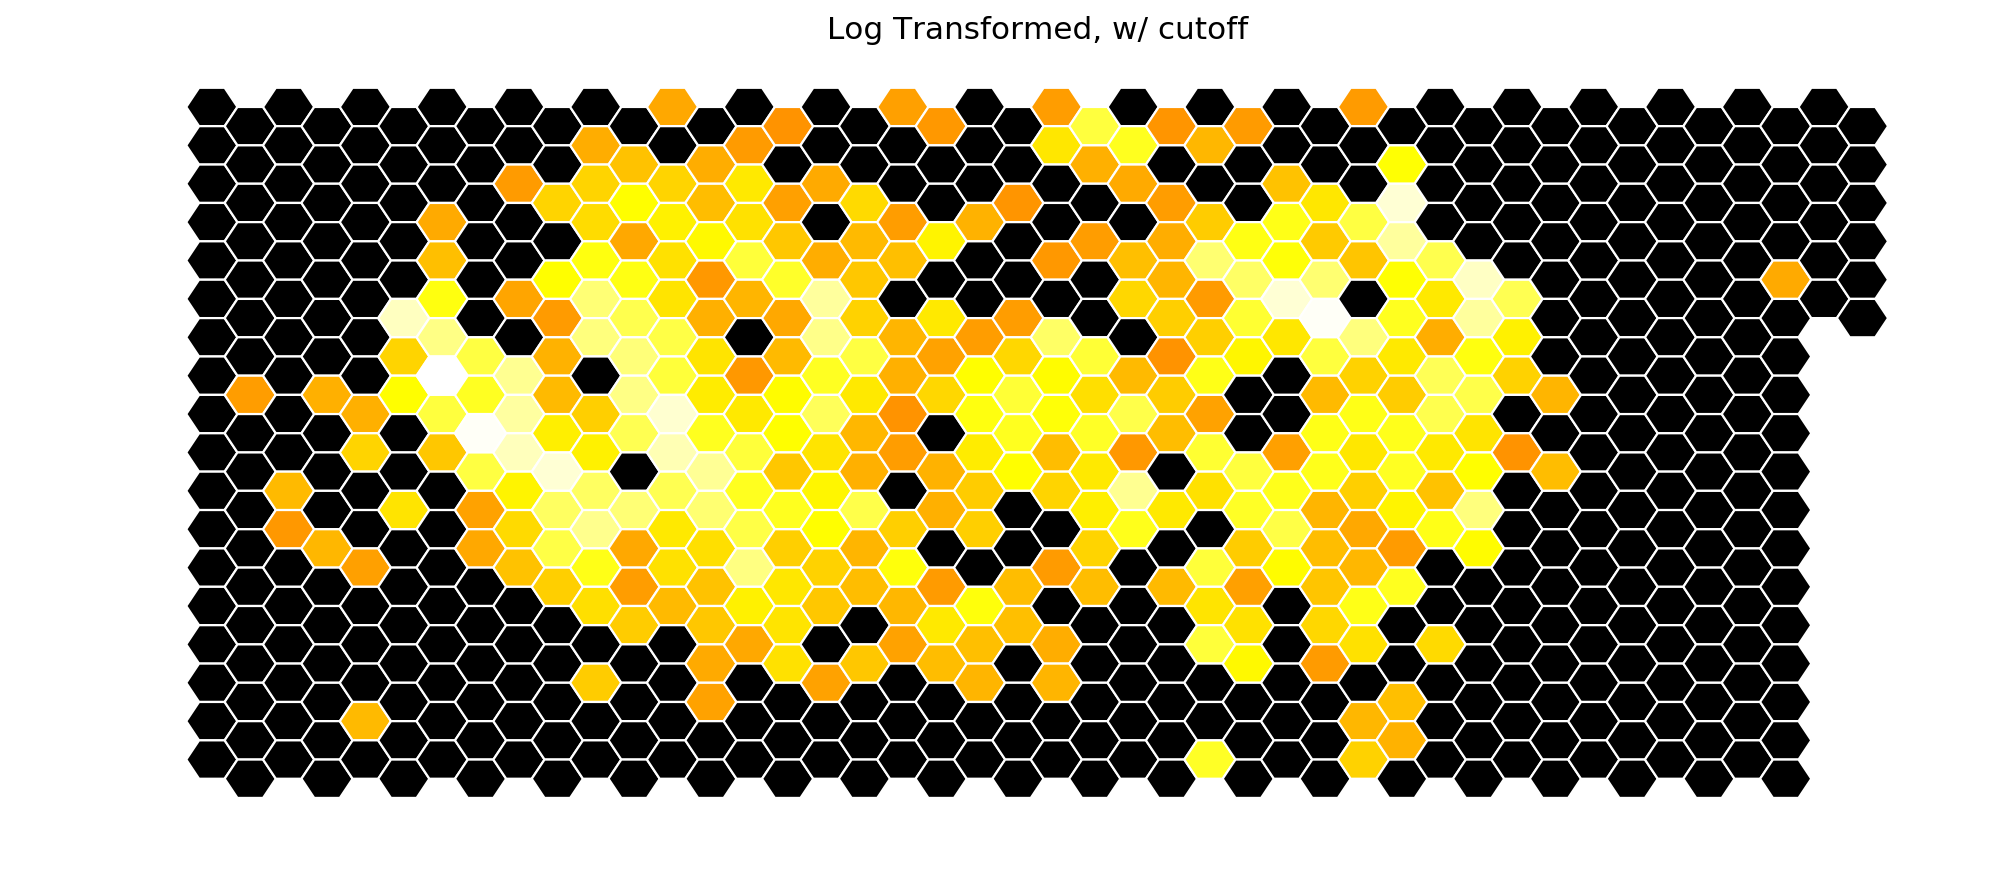

In [404]:
##plot the spatial array

for index, row in map_array.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    
    hexagon(row['X'],row['Y'],row['color'])

    
plt.ylim(18,0) #flip y axis
plt.axis('scaled')
plt.title('Log Transformed, w/ cutoff')
plt.axis('off')

plt.Figure()



In [219]:

#call tissue wells and get metrtics for bulk data per spatial coordinate
#call cells with associated well barcode indices

#UMIs per spatial barcode

#genes per spatial barcode


In [243]:
##scanpy tsne UMAP

sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file = './write/results.h5ad'

#sc.settings = True

adata=sc.read(path + 'matrix.mtx', cache=True).T

adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]

adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 

#adata.obs_names=pd.read_csv(path + 'barcodes.tsv', header=None)



scanpy==1.3.2 anndata==0.6.11 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
... reading from cache file ./cache/data-20181110_DSP-matrix.h5ad


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [245]:
adata.var_names_make_unique()

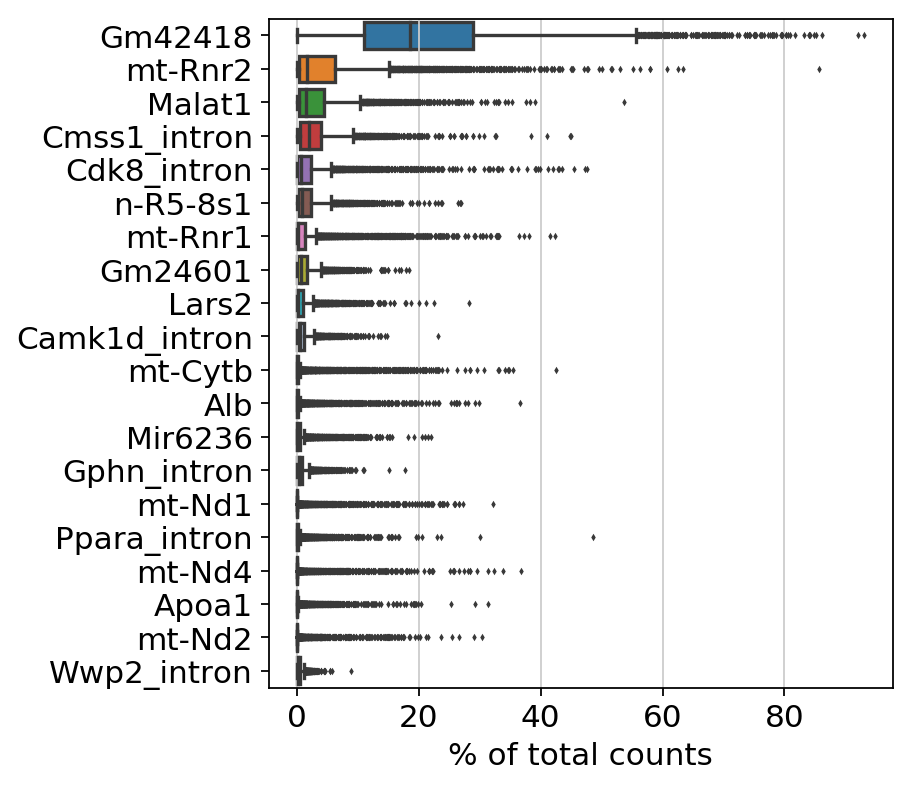

In [247]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [248]:
sc.pp.filter_cells(adata, min_counts=500)
sc.pp.filter_cells(adata, min_genes=100) 
sc.pp.filter_genes(adata, min_cells=3)


mito_genes=[name for name in adata.var_names if name.startswith('mt-')]

adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 3699 cells that have less than 500 counts
filtered out 576 cells that have less than 100 genes expressed
filtered out 71530 genes that are detected in less than 3 cells


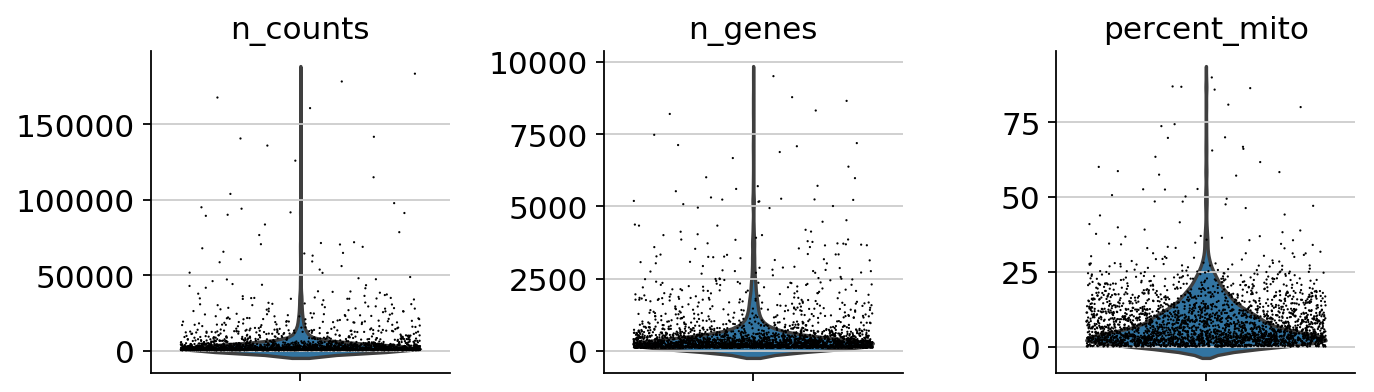

In [249]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [250]:
adata = adata[adata.obs['n_genes'] < 20000, :]
adata = adata[adata.obs['n_counts'] < 20000, :]
adata = adata[adata.obs['percent_mito'] < 20, :]

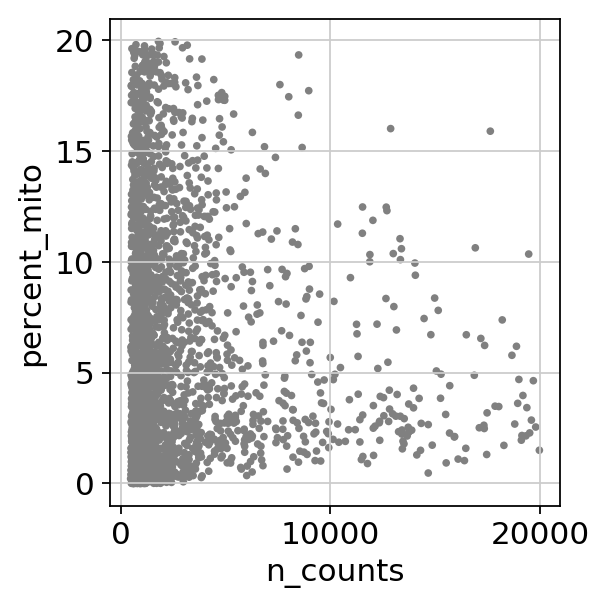

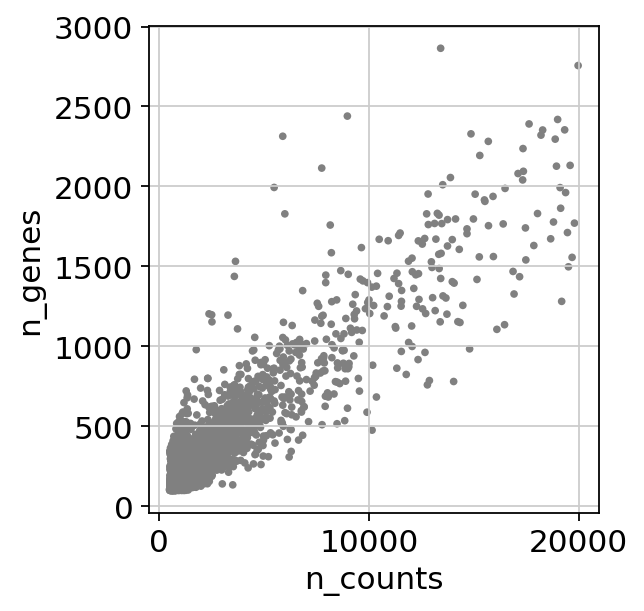

In [251]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [252]:
adata

AnnData object with n_obs × n_vars = 2512 × 35228 
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

In [253]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [254]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

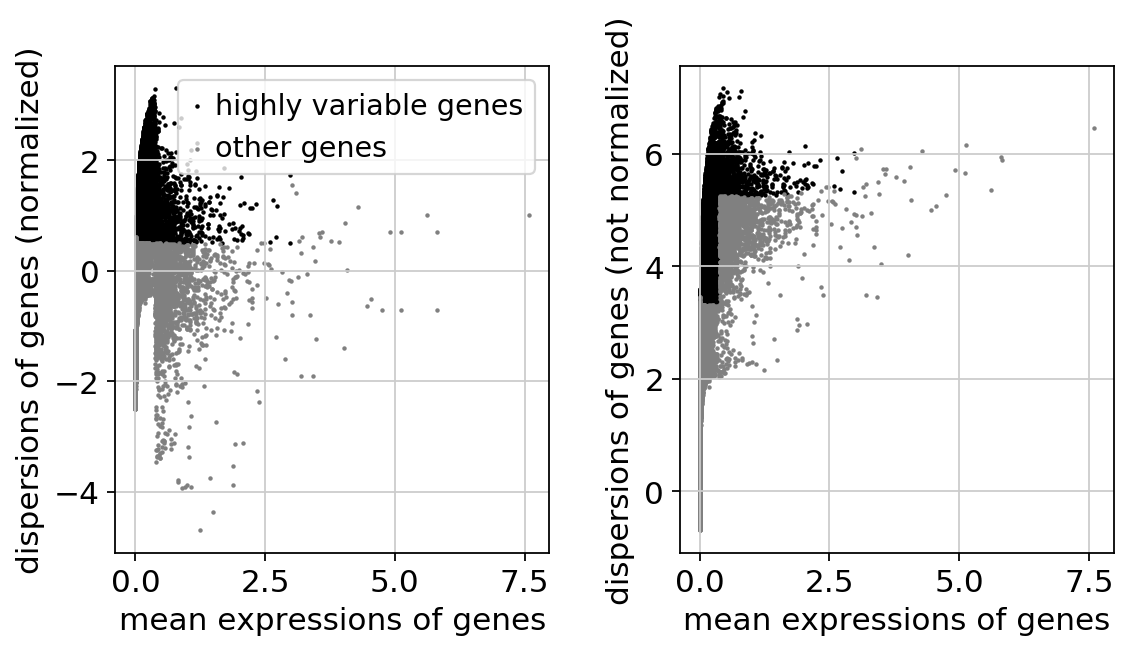

In [255]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [256]:
adata = adata[:, filter_result.gene_subset]

In [257]:
sc.pp.log1p(adata)

In [258]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:24.55)


In [263]:
sc.pp.scale(adata, max_value=10)

In [264]:
adata.write(results_file)

In [265]:
sc.tl.pca(adata, svd_solver='arpack')

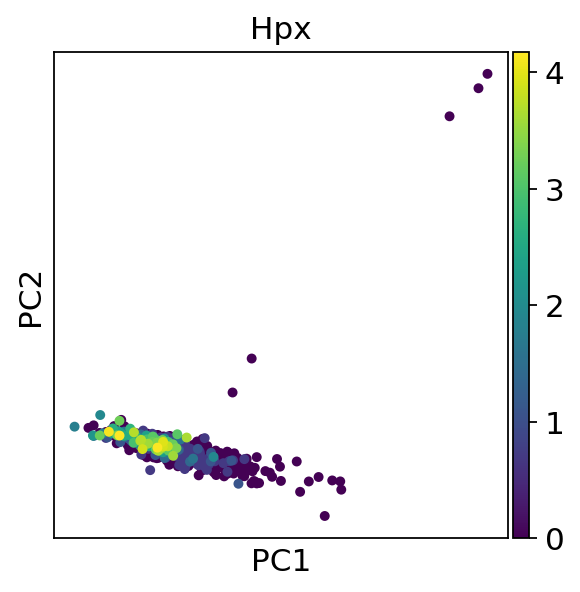

In [266]:
sc.pl.pca(adata, color='Hpx')

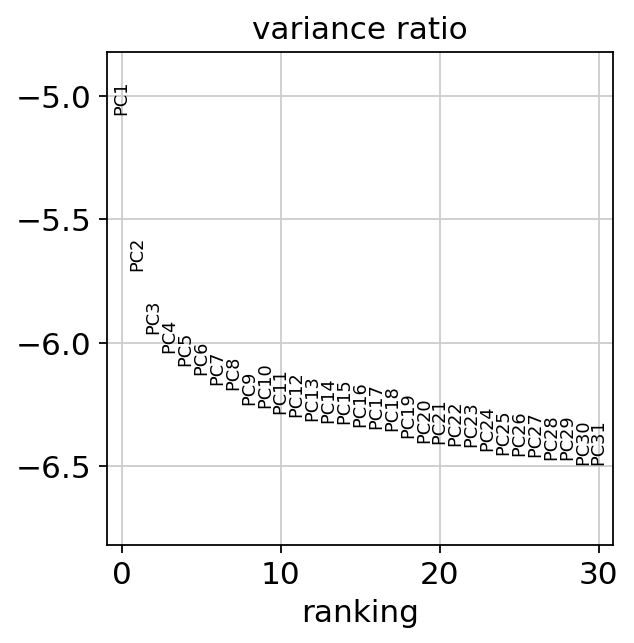

In [267]:
sc.pl.pca_variance_ratio(adata, log=True)

In [268]:
adata.write(results_file)

In [269]:
adata = sc.read(results_file)

In [270]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.59) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


In [271]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.15) --> found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [272]:
 sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:19.74) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


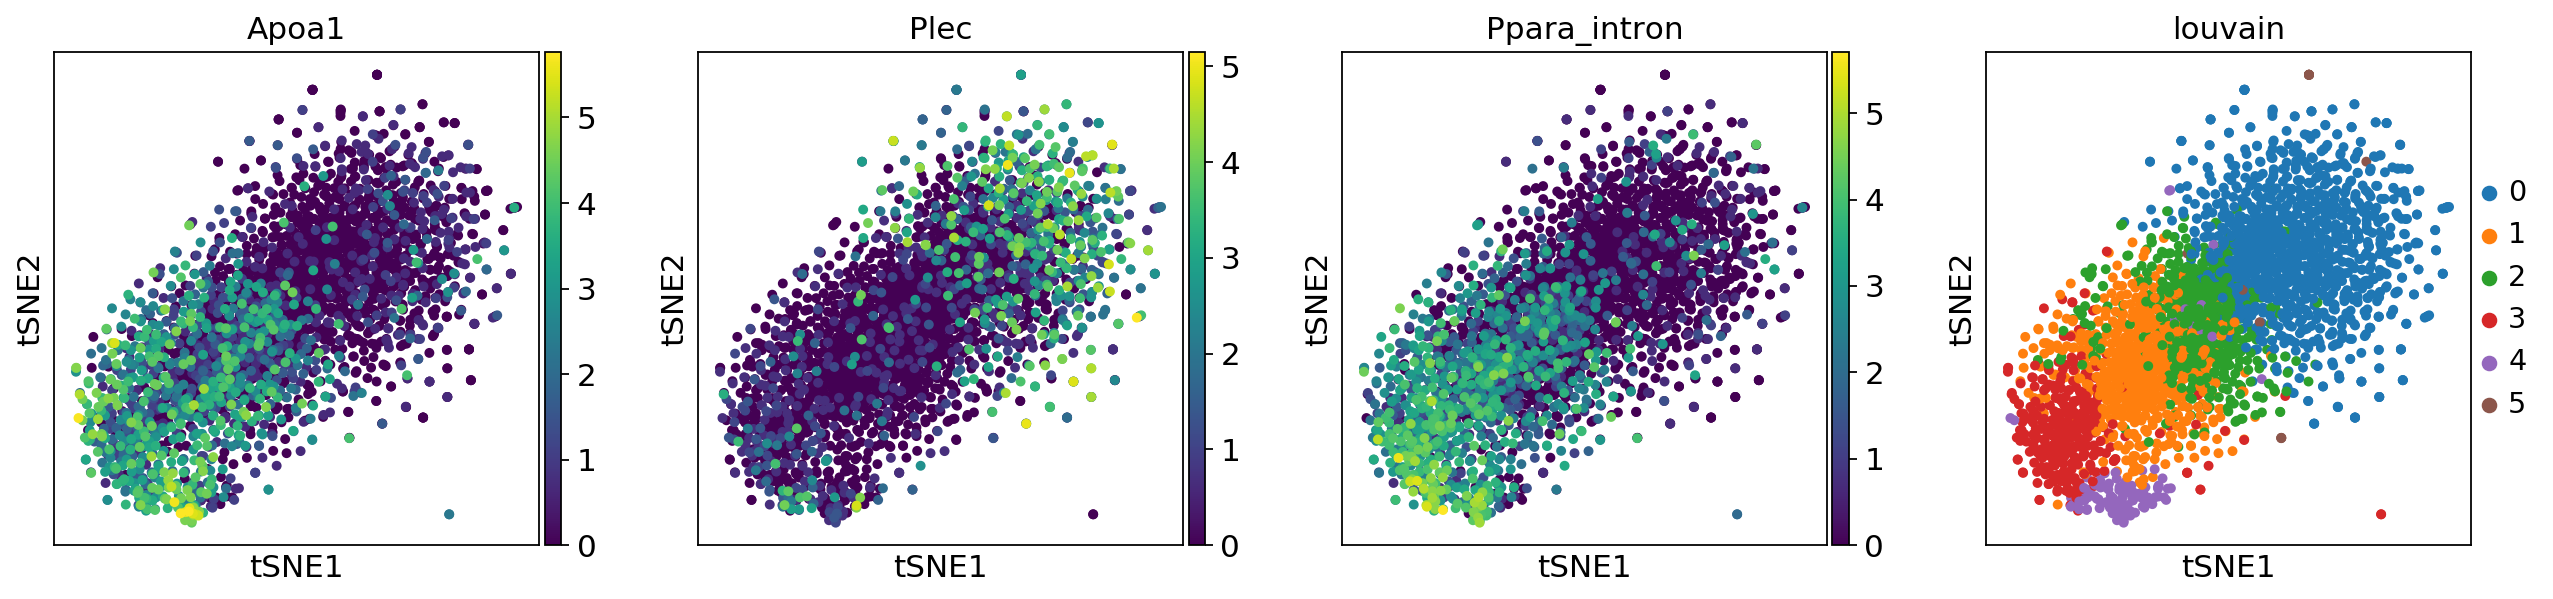

In [273]:
sc.pl.tsne(adata, color=['Apoa1', 'Plec', 'Ppara_intron', 'louvain'])

In [274]:
#sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [275]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03.79) --> added
    'X_umap', UMAP coordinates (adata.obsm)


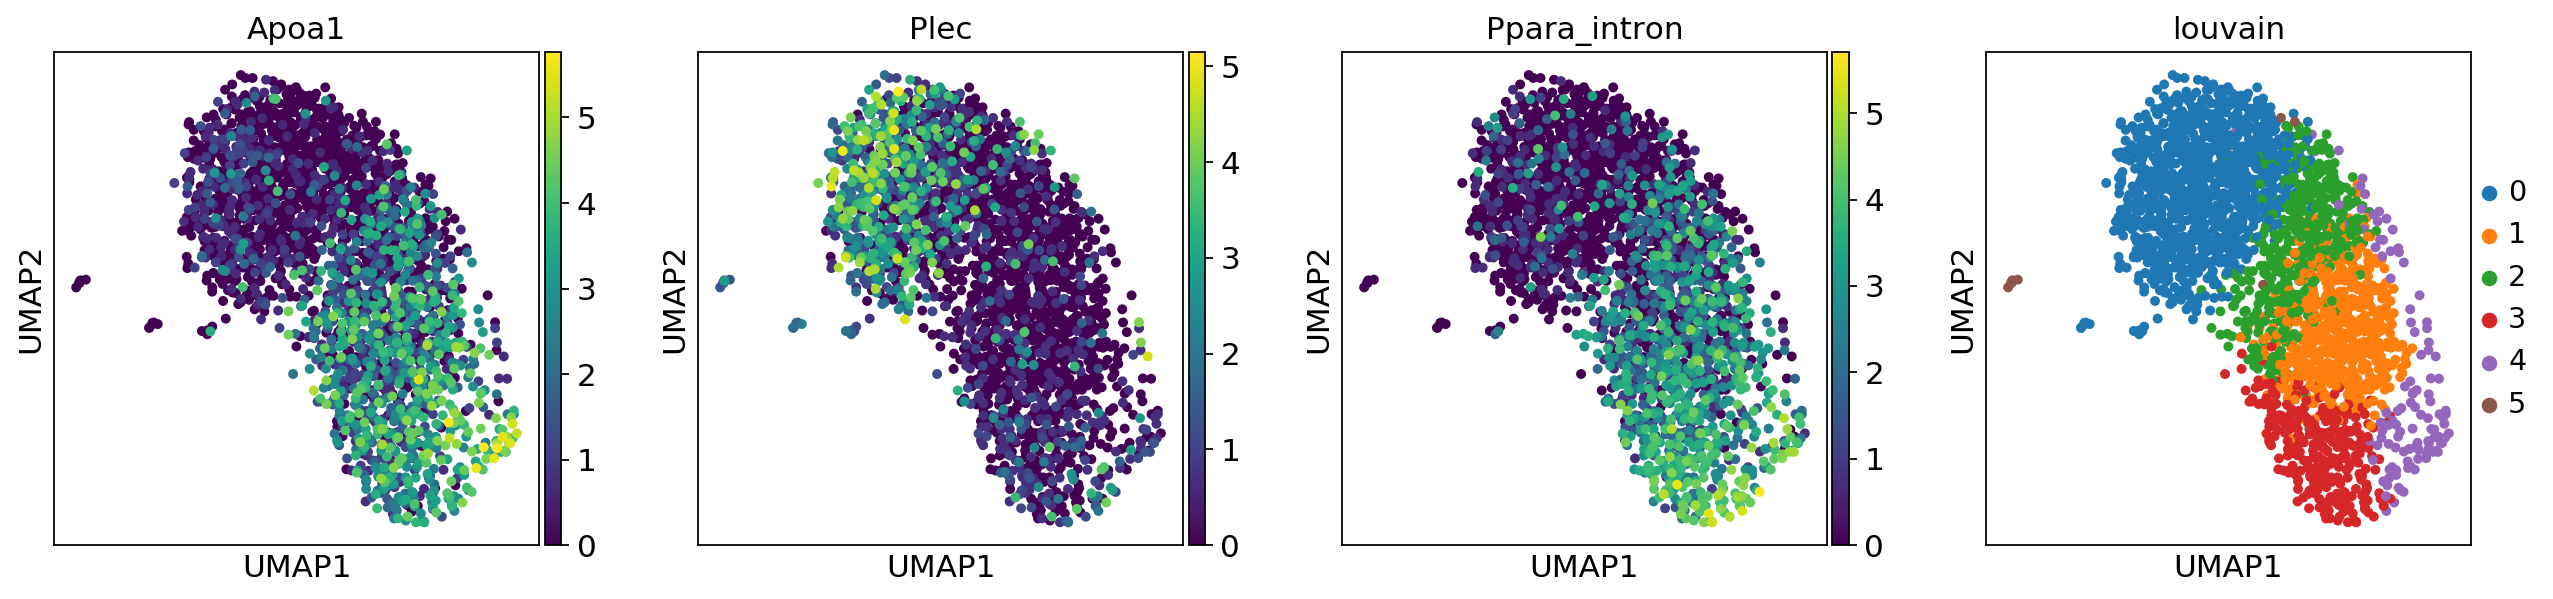

In [276]:
sc.pl.umap(adata, color=['Apoa1', 'Plec', 'Ppara_intron', 'louvain'])

In [277]:
adata.write(results_file)

In [278]:
sc.tl.rank_genes_groups(adata, 'louvain')

ranking genes
    finished (0:00:00.25) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


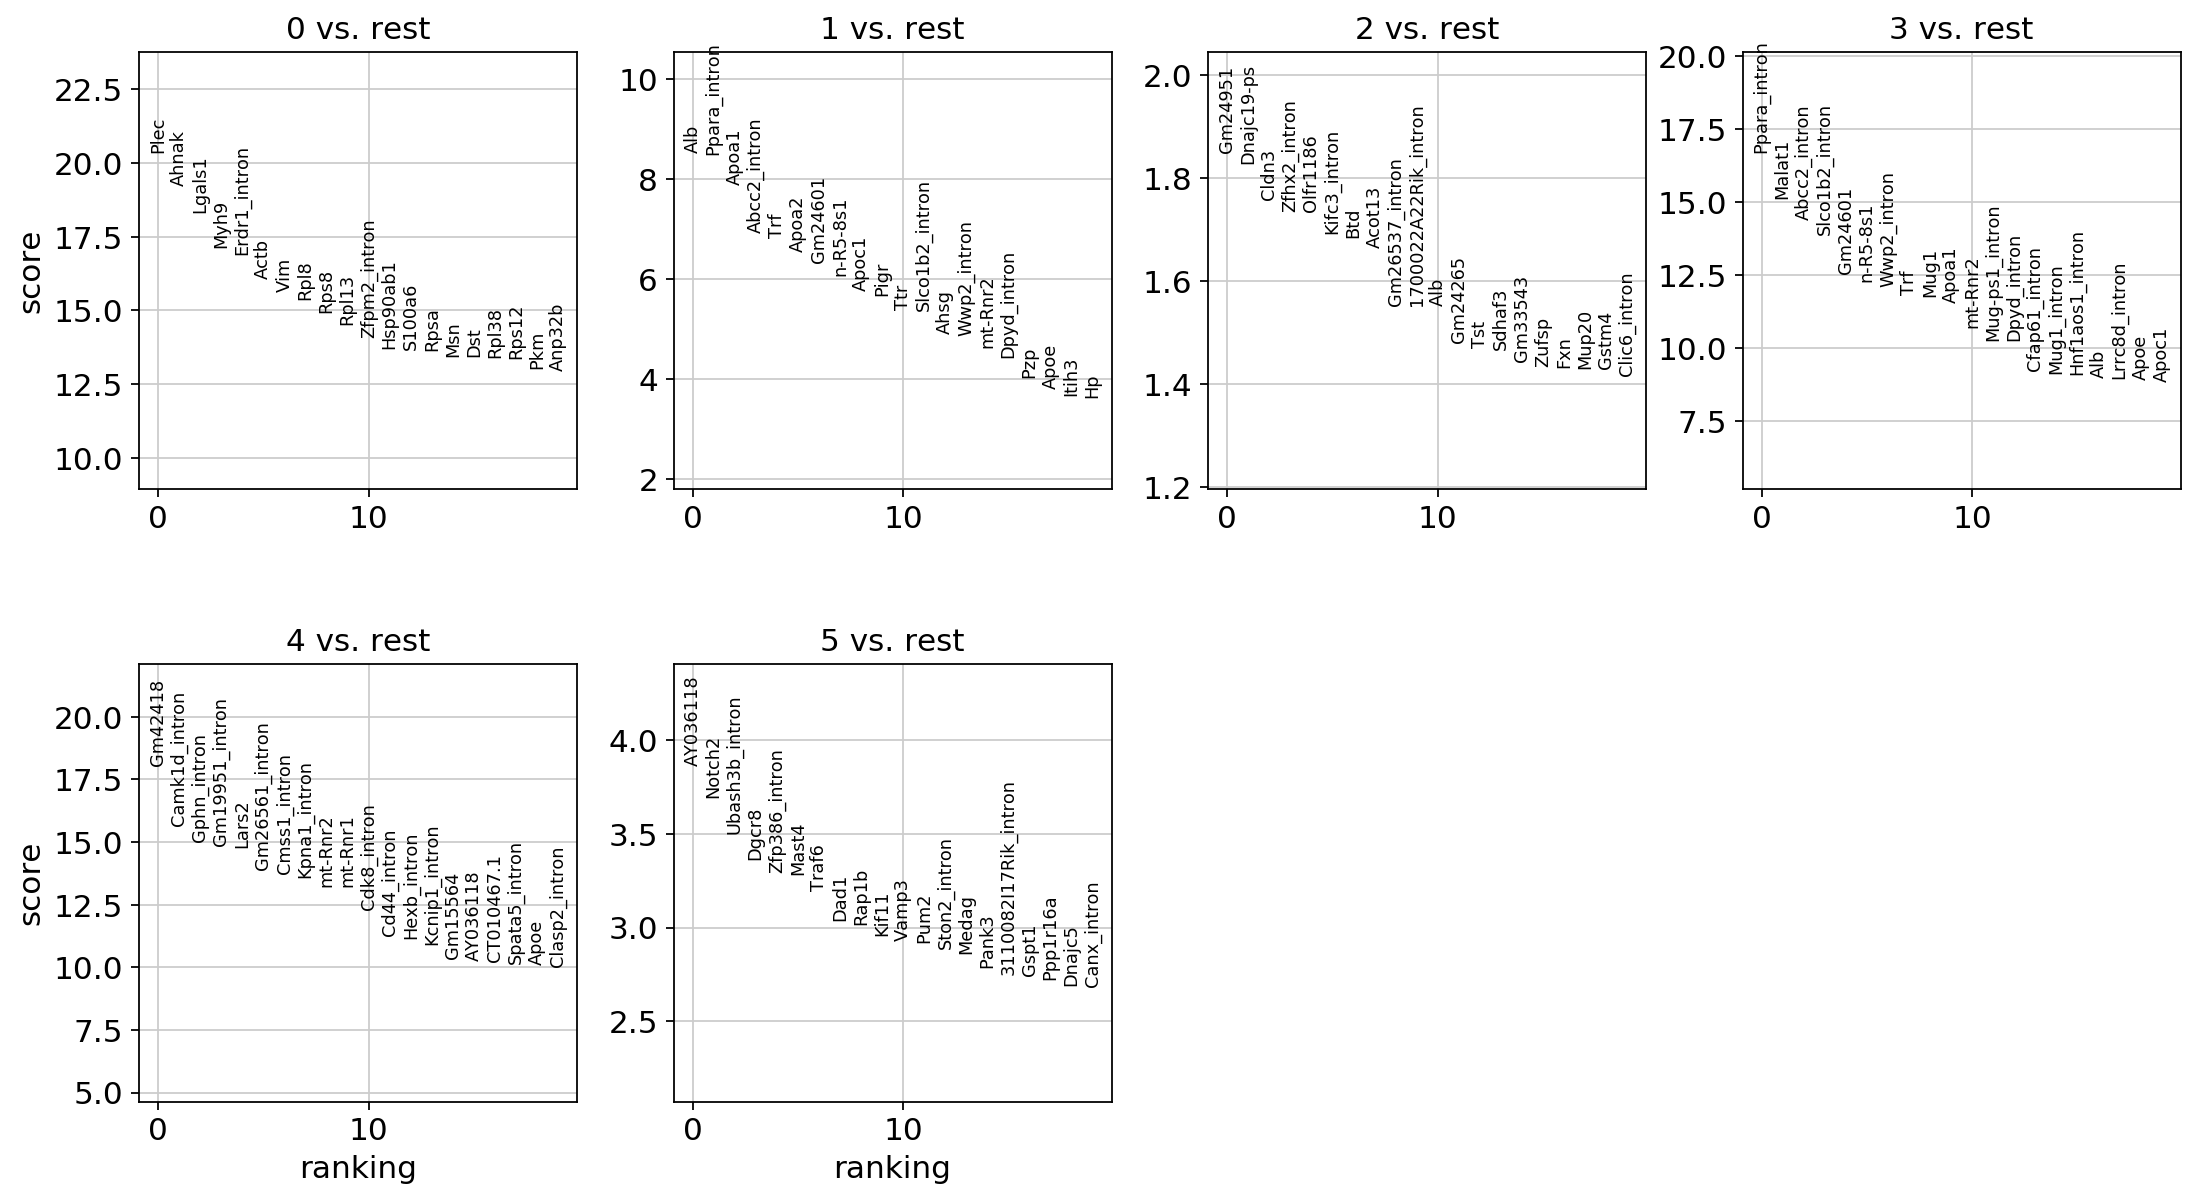

In [279]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [368]:
pd.DataFrame(adata.obs)

,n_counts,n_genes,percent_mito,louvain
index,,,,
A14.CACCGCCAGTAATCAA,887.0,106,12.175874,2
A14.CCTAGCTCCAGTATTA,2059.0,306,3.254007,3
A14.GCTCGCAGATAACTCG,2007.0,309,10.363727,1
A14.ATGCTCCATTCTCGCA,6901.0,624,4.897841,4
A14.TTGAGTGGTGGAGACA,2065.0,340,8.765133,1
A14.AGTAGTATCTTACCGG,1587.0,263,4.914934,1
A14.CCTGTAGTCATCGATT,4637.0,640,4.270002,0
A14.CTTCCTATCTTACGGT,785.0,115,6.878981,0
A14.GGTTCCTAATAGACAC,759.0,159,4.216074,0


In [408]:
df=pd.read_csv('test.csv')
df['index']=df['index'].str[-16:]

#df.groupby(['index'])['louvain'].median()

df1=df.loc[df['louvain'] == 0]

df2=df1.groupby(['index'])['louvain'].median().reset_index()

df2.columns=['barcode','louvain']

df_array=spatial_map.merge(df2, on='barcode', how='left')
df_array=df_array.fillna(1)







#log transform
df_array['louvain']=np.log(df_array['louvain']+1)

#match colors to counts
max_val=max(df_array['louvain'])

norm = mpl.colors.Normalize(vmin=0,vmax=max_val)

count_hex=[]





count_hex=[]

for i in df_array['louvain']:
    if i > 0:
        count_hex.append(mpl.colors.rgb2hex(cm.hot(norm(i))[:3]))
    else:
        count_hex.append('#00B645')

df_array['color']=count_hex



(-1.8833333333333329, 46.88333333333333, 19.425, -0.925)

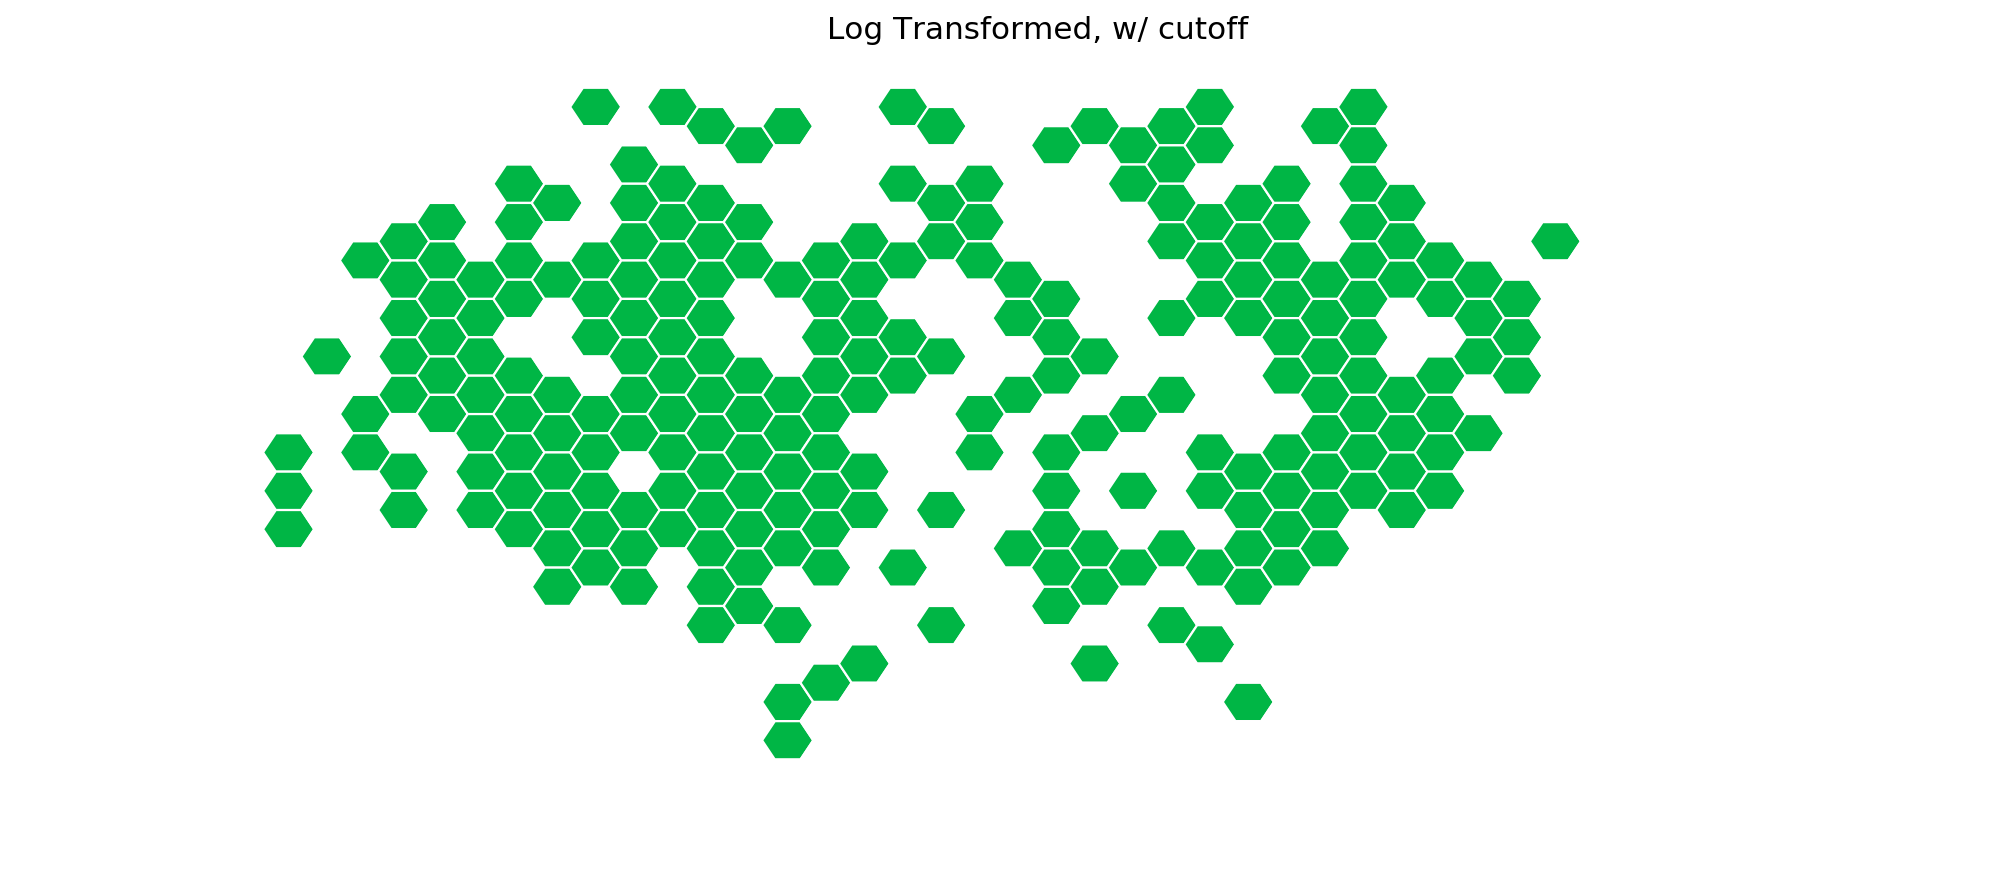

In [409]:
##plot the spatial array

for index, row in df_array.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    
    hexagon(row['X'],row['Y'],row['color'])

    
plt.ylim(18,0) #flip y axis
plt.axis('scaled')
plt.title('Log Transformed, w/ cutoff')
plt.axis('off')



